## Weather map
This file generates the weather map shown in the paper. 

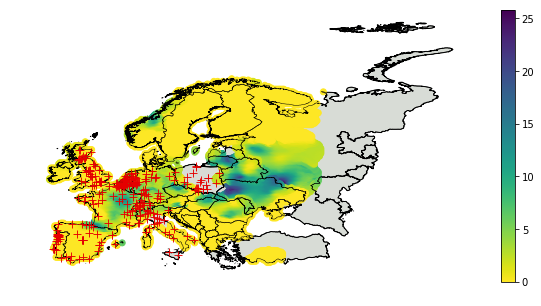

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import os 
import xarray as xr
import gzip
%matplotlib inline

#Load shape file
#https://automating-gis-processes.github.io/2017/lessons/L2/projections.html
europe = gpd.read_file(os.getcwd()+'\\raw_data\\Weather\\shape\\Europe_borders.shp')
#europe.plot()


###Load weather data 
# https://www.ecad.eu/download/ensembles/downloadchunks.php
with gzip.open(os.getcwd() + '\\raw_data\\Weather\\rr_0.25deg_reg_2011-2017_v17.0.nc.gz') as f: 
#    weather_2011 = xr.open_dataset(f)
    weather = xr.open_dataset(f)
#with gzip.open(os.getcwd() + '\\raw_data\\Weather\\rr_0.25deg_reg_1995-2010_v17.0.nc.gz') as f: 
#    weather_1995 = xr.open_dataset(f)    
#weather = xr.concat([weather_1995,weather_2011], dim='time')
##weather = weather.to_dataframe()
#del weather_2011, weather_1995

#Load stadiums
stadiums = pd.read_csv('main_df.csv')
stadiums = stadiums[['coordinates', 'venueLabel', 'league']]
stadiums.drop_duplicates(inplace=True)
stadiums['longitude'], stadiums['latitude'] = stadiums['coordinates'].str.split(" ").str #.replace('Point(', ''))
stadiums['longitude'] = stadiums['longitude'].str.replace('Point\(', '').astype(float)
stadiums['latitude'] = stadiums['latitude'].str.replace('\)', '').astype(float)
geom = [shapely.geometry.Point(x,y) for x, y in zip(stadiums['longitude'], stadiums['latitude'])]
stadiums = gpd.GeoDataFrame(stadiums, geometry=geom)
del geom

#print(europe.total_bounds)
stadiums = stadiums[(stadiums['longitude']>europe.total_bounds[0])&(stadiums['longitude']<europe.total_bounds[2])]
stadiums = stadiums[(stadiums['latitude']>europe.total_bounds[0])&(stadiums['latitude']<europe.total_bounds[2])]

date = '2017-07-01'

weatherdf = weather.sel(time=date).to_dataframe().reset_index()
geom = [shapely.geometry.Point(x,y) for x, y in zip(weatherdf['longitude'], weatherdf['latitude'])]
weatherdf = gpd.GeoDataFrame(weatherdf, geometry=geom)
del weather , geom 

figure_data = gpd.sjoin(weatherdf, europe, how='inner', op='intersects')

fig, ax = plt.subplots(1,  figsize=(10,5))
base1 = europe.plot(ax=ax, edgecolor='black', facecolor='xkcd:light gray')
base2 = figure_data.plot(ax=base1, column='rr', legend =True, cmap='viridis_r')
base3 = europe.plot(ax=base2, edgecolor='black', linewidth=0.5, facecolor='none')
#stadiums.plot(ax=base, marker='+', c=stadiums['league'].astype('category').cat.codes, cmap='viridis')
stadiums.plot(ax=base3, marker='+', color='xkcd:red', 
              linewidth = 0.9, markersize=50, alpha=1)
#
_ = ax.axis('off')

plt.savefig(os.getcwd() + '\\work_files\\'+'weather_map.eps', format='eps',bbox_inches='tight')
plt.show()